In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import functools

from pymicro.file import file_utils
import tensorflow as tf
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics as met

from tomo2seg.data import volume_precipitates_dryrun as volume_paths, ModelPaths
from tomo2seg.volume_img_segm import VolumeImgSegmSequence
from tomo2seg import viz

In [3]:
dimensions = (500, 500, 500)
dtype = "uint8"  # todo remove the cast inside the generator?

# prefill the function `HST_read`
_hst_read = functools.partial(
    file_utils.HST_read,
    autoparse_filename=False,  # the file names are not properly formatted
    data_type=dtype,
    dims=dimensions,
    verbose=True,
)

hst_read = lambda x: _hst_read(str(x))

labels_list = [0, 1, 2]

class labels:
    matrix = 0
    fiber = 1
    hole = 2

In [4]:
val = VolumeImgSegmSequence(
    # get a 3d np array
    source_volume=hst_read(volume_paths.val_data_path),  
    label_volume=hst_read(volume_paths.val_labels_path),  
    labels=labels_list,  # the classes encodings
    axes=(2,),  # z-axis slices only
    batch_size=1,
    shuffle=False, 
    normalization_const=255,
    n_geometric_augmentations=0,  # only the original slices as is
#     crop_size=500,  # no crop, get the whole slice
    crop_size=224,  
)

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0
data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


In [5]:
val_volume = hst_read(volume_paths.val_data_path)
val_volume.shape

data type is uint8
volume size is 500 x 500 x 500
reading volume... from byte 0


(500, 500, 500)

# Reference segmentation

## Train volume


## Validation volume

# Model

In [6]:
model_name = "dryrun-03"
model_paths = ModelPaths(model_name)

In [7]:
model = tf.keras.models.load_model(str(model_paths.autosaved_model_path) + ".hdf5")

# Predict

## Train

## Validation

In [9]:
from tqdm import tqdm

In [10]:
val_pred = [
    model.predict(x)
    for x in tqdm(val)
]

100%|██████████| 2000/2000 [14:56<00:00,  2.23it/s]


In [11]:
val_pred = np.concatenate(val_pred, axis=0)

In [12]:
np.save("val-pred-probas.npy", val_pred)

In [13]:
val_pred = np.load("val-pred-probas.npy")

In [14]:
val_pred = val_pred.argmax(axis=3)

In [16]:
np.save("val-pred-classes.npy", val_pred)

In [17]:
val_pred = np.load("val-pred-classes.npy")

# Examples

In [18]:
from skimage import data, segmentation
from skimage import filters
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

def plot_border(idx, generator, predictions):    
    img = generator[idx][0].reshape(224, 224)
    gt = val[idx][1].reshape(224, 224, 3).argmax(axis=2)
    pred = predictions[idx]

    gt_mask_fiber = gt == labels.fiber
    gt_mask_hole = gt == labels.hole
    
    gt_edges_fiber = segmentation.find_boundaries(gt_mask_fiber)
    gt_edges_fiber = np.ma.masked_where(~gt_edges_fiber, gt_edges_fiber)

    gt_edges_hole = segmentation.find_boundaries(gt_mask_hole)
    gt_edges_hole = np.ma.masked_where(~gt_edges_hole, gt_edges_hole)
    
    pred_mask_fiber = pred == labels.fiber
    pred_mask_hole = pred == labels.hole
    
    pred_edges_fiber = segmentation.find_boundaries(pred_mask_fiber)
    pred_edges_fiber = np.ma.masked_where(~pred_edges_fiber, pred_edges_fiber)

    pred_edges_hole = segmentation.find_boundaries(pred_mask_hole)
    pred_edges_hole = np.ma.masked_where(~pred_edges_hole, pred_edges_hole)

    sz = 10
    fig, axs = plt.subplots(2, 2, figsize=(sz, sz), dpi=200)
    fig.tight_layout()
    for ax in axs.ravel():
        ax.axis('off')
    
    # upper left
    axs[0, 0].imshow(img, cmap='gray')
    axs[0, 0].set_title("Image")
    
    # upper right
    axs[0, 1].imshow(img, cmap='gray')
    axs[0, 1].imshow(gt_edges_fiber, cmap=ListedColormap(['blue']), interpolation=None)
    axs[0, 1].imshow(gt_edges_hole, cmap=ListedColormap(['yellow']), interpolation=None)
    axs[0, 1].set_title("Ground truth")
    
    # bottom left
    axs[1, 0].imshow(img, cmap='gray')
    axs[1, 0].imshow(pred_edges_fiber, cmap=ListedColormap(['red']), interpolation=None)
    axs[1, 0].imshow(pred_edges_hole, cmap=ListedColormap(['magenta']), interpolation=None)
    axs[1, 0].set_title("Prediction")
    
    # bottom right
    axs[1, 1].imshow(img, cmap='gray')
    axs[1, 1].imshow(gt_edges_fiber, cmap=ListedColormap(['blue']), interpolation=None)
    axs[1, 1].imshow(gt_edges_hole, cmap=ListedColormap(['yellow']), interpolation=None)
    axs[1, 1].imshow(pred_edges_fiber, cmap=ListedColormap(['red']), interpolation=None)
    axs[1, 1].imshow(pred_edges_hole, cmap=ListedColormap(['magenta']), interpolation=None)
    axs[1, 1].set_title("Ground truth X Prediction")
 
    
plot_border_val = functools.partial(plot_border, generator=val, predictions=val_pred)  

In [19]:
def plot_pred(generator, predictions, idx, label):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    viz.show_slice(
        ax, 
        generator[idx][0].reshape(224, 224), 
        (~(predictions[idx] == label)).astype(int)
    )
    

def plot_label(generator, idx, label):
    fig, ax = plt.subplots(1, 1, figsize=(12, 12))
    viz.show_slice(
        ax, 
        generator[idx][0].reshape(224, 224), 
        (~(generator[idx][1].reshape(224, 224, 3).argmax(axis=2) == label)).astype(int)
    )

In [20]:
# plot_train_label = functools.partial(plot_label, generator=train)
# plot_train_pred = functools.partial(plot_pred, generator=train, predictions=train_pred)

plot_val_label = functools.partial(plot_label, generator=val)
plot_val_pred = functools.partial(plot_pred, generator=val, predictions=val_pred)

# Find some bad segmentations

## Image accuracy

In [21]:
accuracies = []
for idx in range(len(val)):
    truth = val[idx][1].reshape(224, 224, 3).argmax(axis=2)
    pred = val_pred[idx]

    accuracies.append(
        (truth == pred).sum() / (truth.shape[0] * truth.shape[1])
    )

In [22]:
accuracies_sort = np.argsort(accuracies)

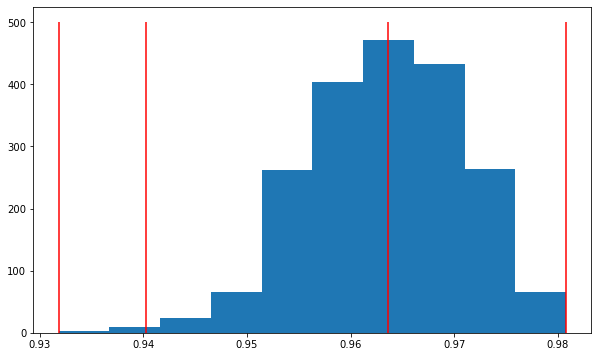

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(accuracies)
ax.vlines([accuracies[accuracies_sort[p]] for p in [0, 10, 1000, -1]], 0, 500, color='red')

Accuracy: 98.1%


/home/joaopcbertoldo/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/joaopcbertoldo/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/joaopcbertoldo/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/joaopcbertoldo/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


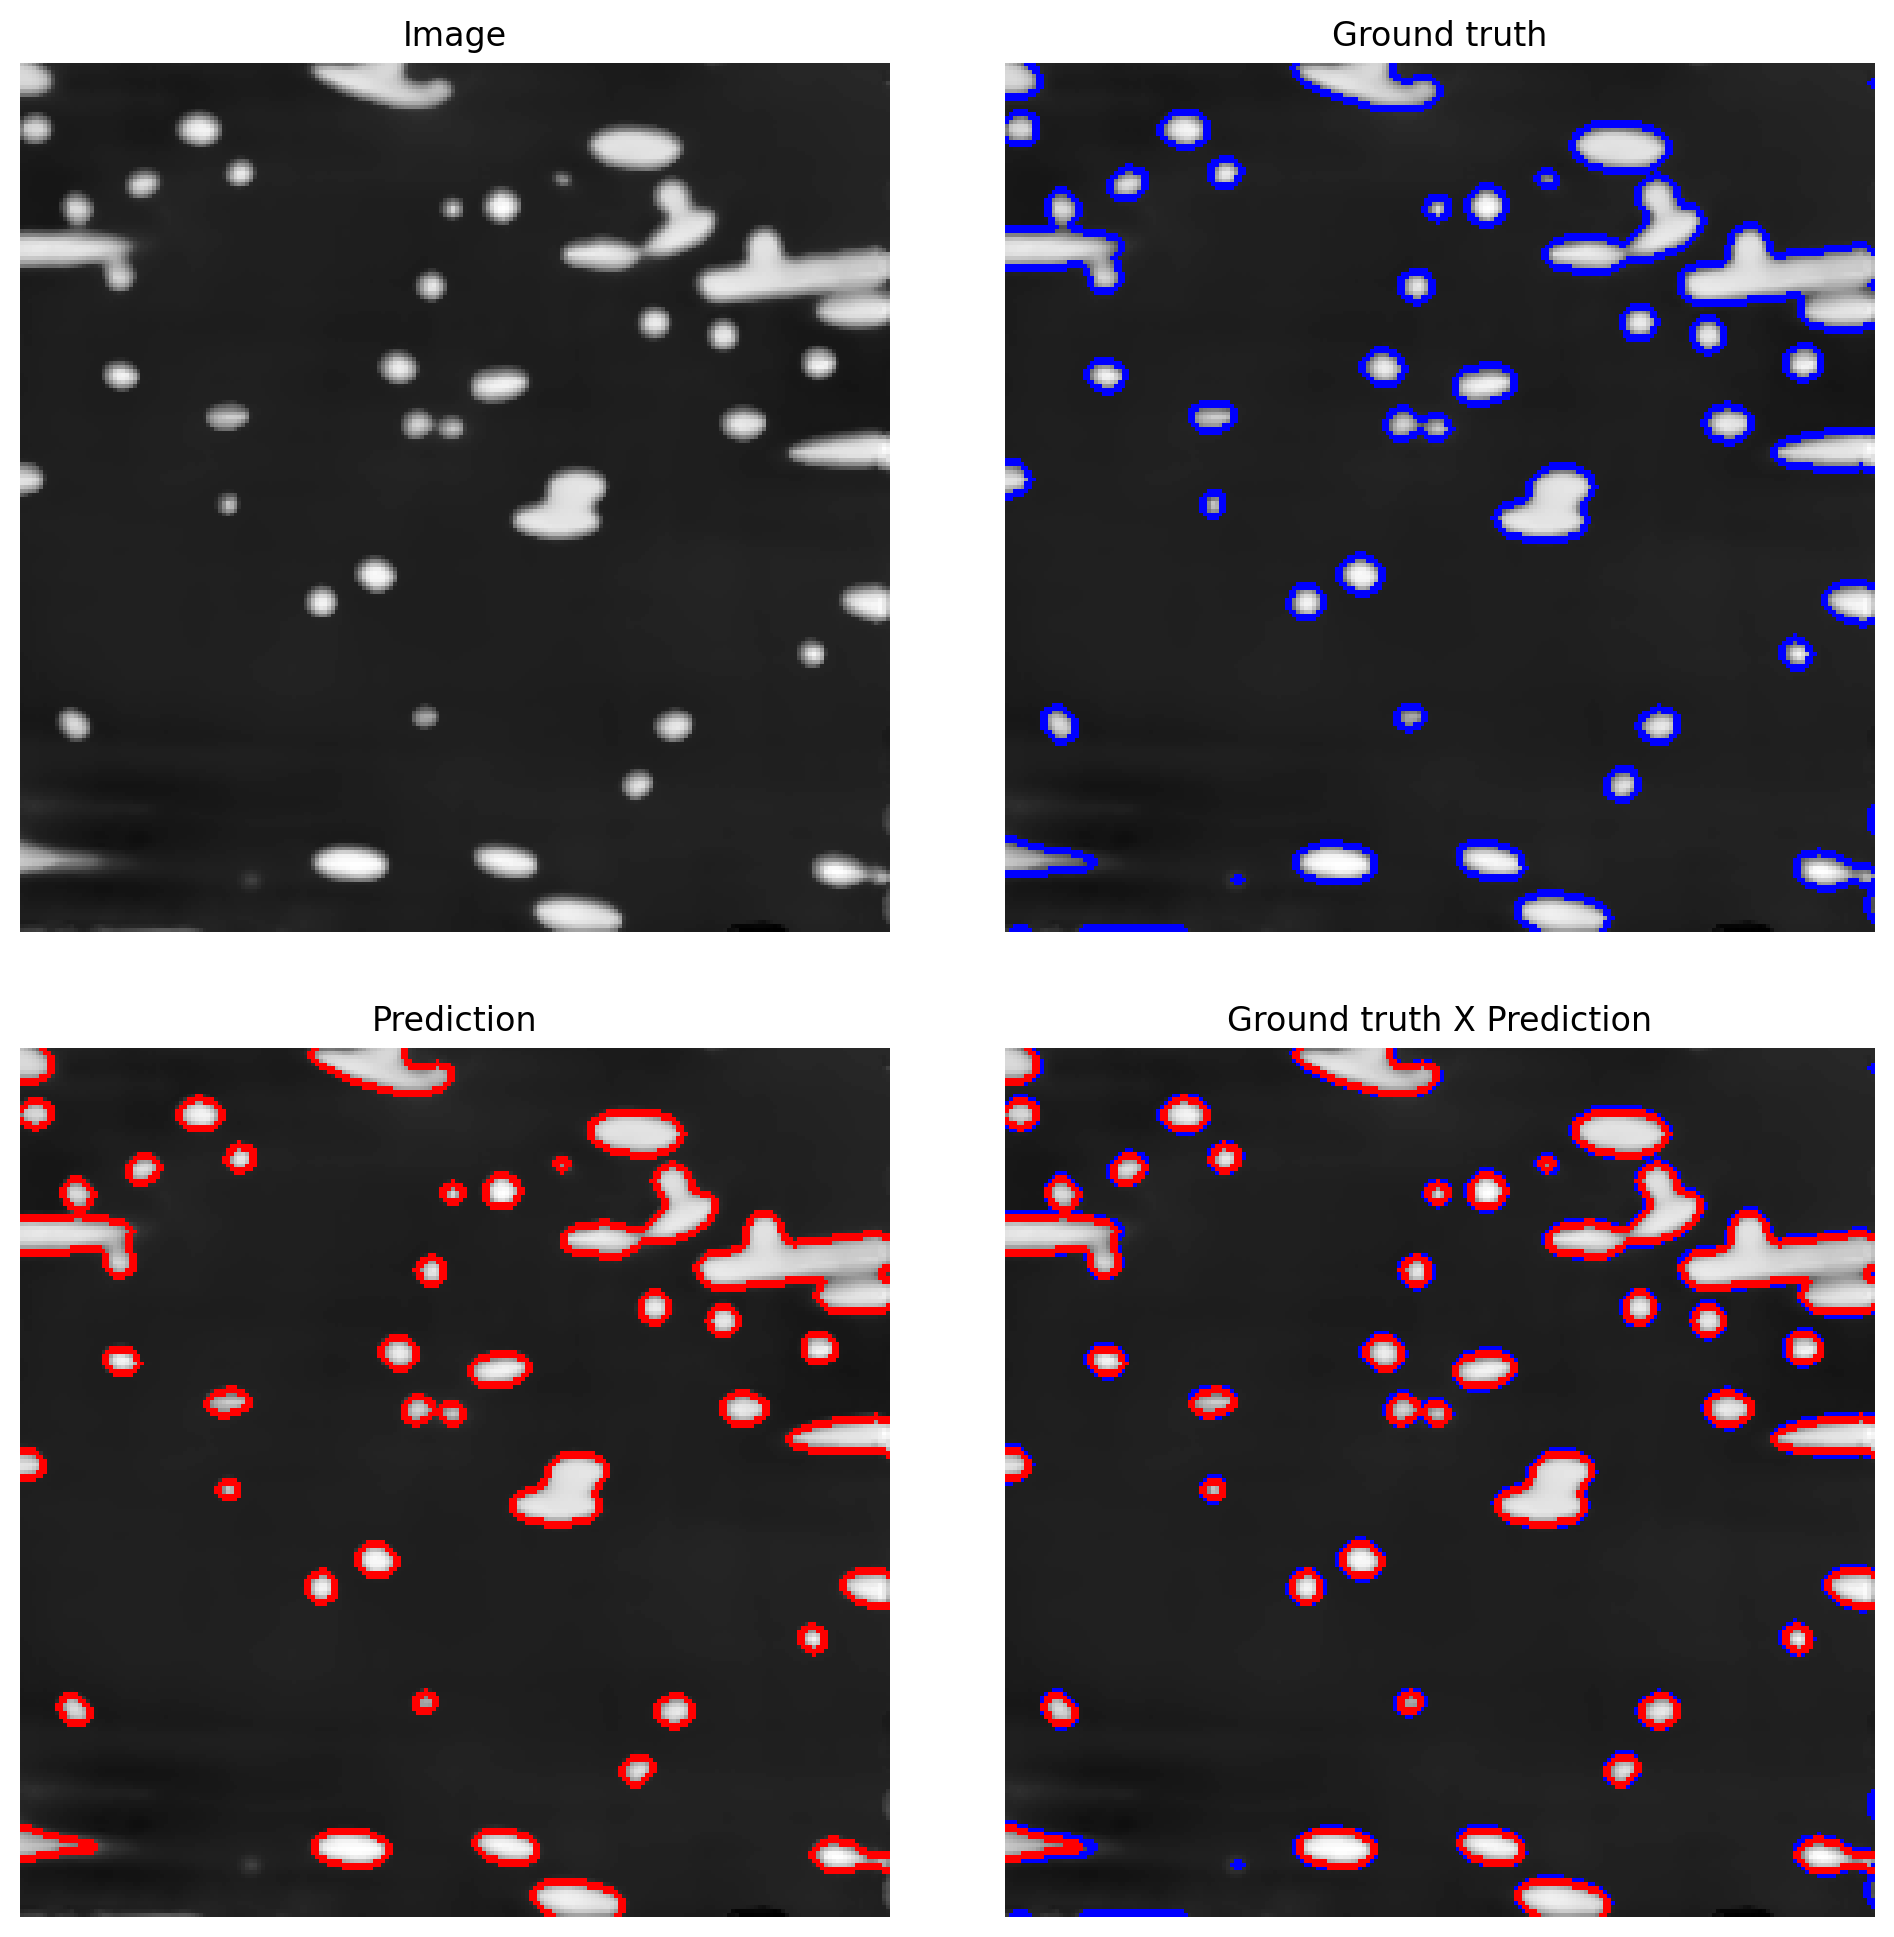

In [24]:
idx = accuracies_sort[-1]
accu = accuracies[idx]
print(f"Accuracy: {accu:.1%}")
plot_border_val(idx)

## Cross entropy

In [25]:
val_pred_probas = np.load("val-pred-probas.npy")

In [26]:
losses = []
for idx in tqdm(range(len(val))):
    truth = val[idx][1].reshape(224, 224, 3).argmax().ravel()
    truth = val[idx][1].reshape(224, 224, 3).reshape(-1, 3)
    pred = val_pred_probas[idx].reshape(-1, 3)

    losses.append(met.log_loss(truth, pred))

100%|██████████| 2000/2000 [00:38<00:00, 51.81it/s]


In [27]:
losses_sort = np.argsort(losses)

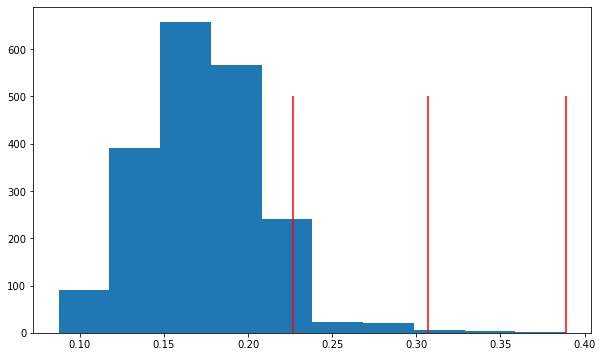

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.hist(losses)
ax.vlines([losses[losses_sort[p]] for p in [-100, -10, -1]], 0, 500, color='red')

Loss: 0.39


/home/joaopcbertoldo/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:446: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/joaopcbertoldo/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:453: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/joaopcbertoldo/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:458: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/home/joaopcbertoldo/projects/tomo2seg/condaenv/lib/python3.8/site-packages/matplotlib/image.py:477: UserWarning: Warning: converting a masked element to nan.
  vrange = np.array([self.norm.vmin, self.norm.vmax],


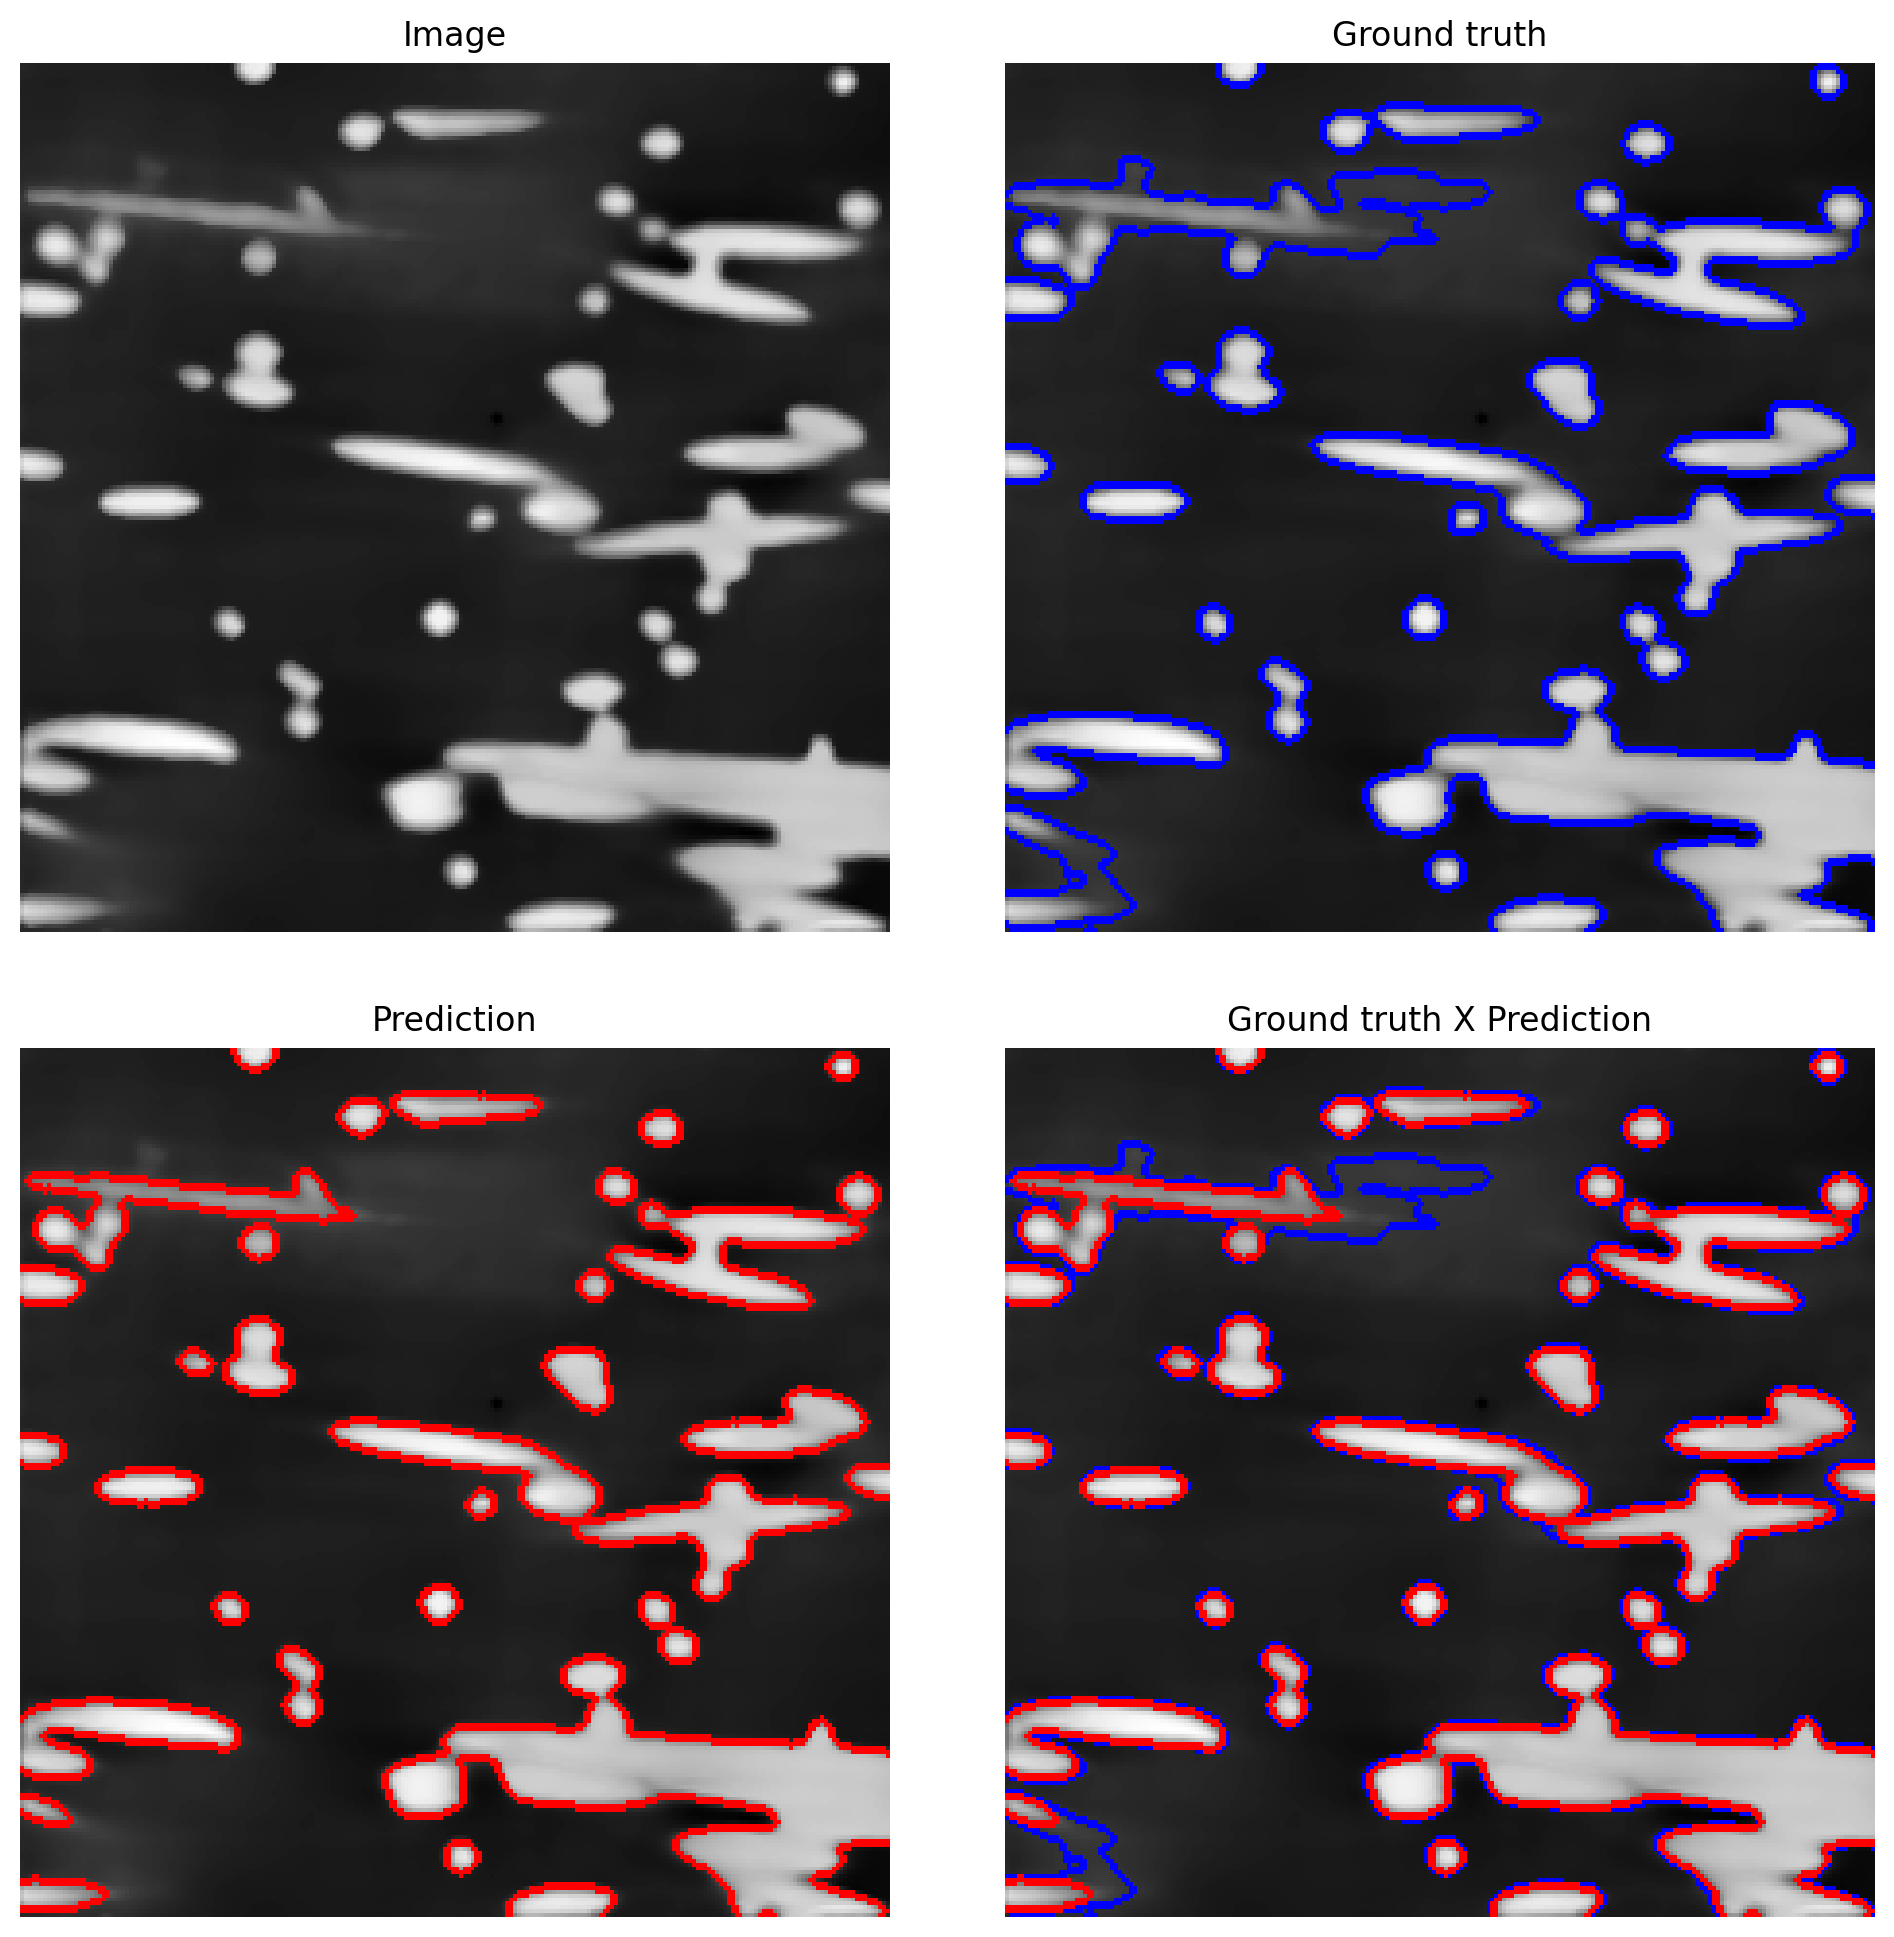

In [29]:
idx = losses_sort[-1]
loss = losses[idx]
print(f"Loss: {loss:.2f}")
plot_border_val(idx)

## Error blobs

In [30]:
idx = 0
generator = val
predictions = val_pred
img = generator[idx][0].reshape(224, 224)
gt = val[idx][1].reshape(224, 224, 3).argmax(axis=2)
pred = predictions[idx]

In [11]:
import skimage

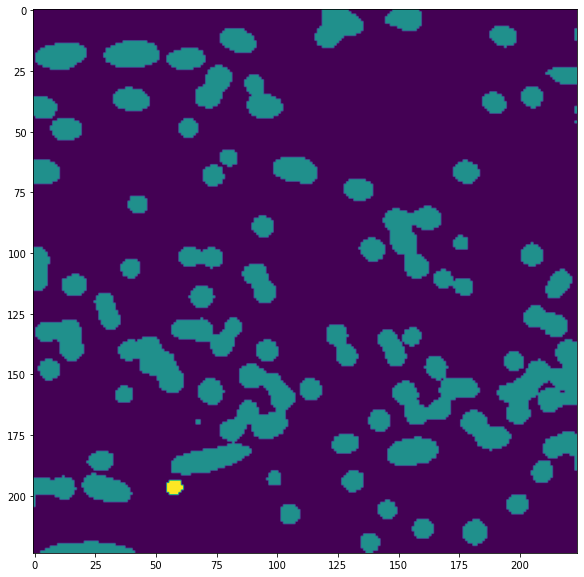

In [33]:
plt.figure(figsize=(10, 10))
plt.imshow(gt)

blobs, n_blobs = skimage.measure.label(gt, connectivity=2, return_num=True, background=0)

In [14]:
n_blobs

75

In [15]:
blob_stack = [(blobs == i).reshape(*blobs.shape, 1) for i in range(n_blobs + 1)]
blob_stack = np.concatenate(blob_stack, axis=2)

In [ ]:
blob